In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils import *
from equations import *

In [2]:
epochADAM = 200000
epochLBFGS=100000
N_u=100
N_f=500
seed=1234
log_frequency=10000
history_frequency=10
NLayers=6
NNeurons=10
noiseLevel=[]
weights = [5,3,5,6,14]

In [3]:
hp = {}
# Data size on the solution u
hp["N_u"] = N_u
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = N_f
# DeepNN topology (1-sized input [x], NLayers hidden layer of NNeurons-width, 1-sized output [u]
hp["layers"] = [1]+[NNeurons]*NLayers+[1]
# DeepNN topology (1-sized input [x], NLayers hidden layer of NNeurons-width, 2-sized output [h, H]
hp["h_layers"] = [1]+[NNeurons]*NLayers+[2]
# DeepNN topology (1-sized input [x], NLayers hidden layer of NNeurons-width, 1-sized output [C]
hp["C_layers"] = [1]+[NNeurons]*NLayers+[1]
# DeepNN topology (1-sized input [x], NLayers hidden layer of NNeurons-width, 4-sized input [u,C], 
#   1-sized output [taub]
hp["friction_layers"] = [2]+[NNeurons]*NLayers+[1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = epochADAM
hp["tf_lr"] = 0.001
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = epochLBFGS
hp["log_frequency"] = log_frequency
# Record the history
hp["save_history"] = True
hp["history_frequency"] = history_frequency
# path for loading data and saving models
repoPath = "./"
appDataPath = os.path.join(repoPath, "matlab_SSA", "DATA")
path = os.path.join(appDataPath, "Helheim_Weertman_iT080_PINN_flowline_CF_2dInv.mat")

loss_weights = [10**(-w) for w in weights]

now = datetime.now()

# check the input
if type(noiseLevel) != list:
    noiseLevel = [] # set to no noise

if noiseLevel:
    modelPath = "./Models/SSA1D_3NN_"+str(NLayers)+"x"+str(NNeurons)+"_noise_" + "".join([str(i)+"_" for i in noiseLevel])+ "weights" + "".join([str(w)+"_" for w in weights]) + now.strftime("%Y%m%d_%H%M%S")
else:
    modelPath = "./Models/SSA1D_3NN_"+str(NLayers)+"x"+str(NNeurons)+"_weights"+ "".join([str(w)+"_" for w in weights]) + now.strftime("%Y%m%d_%H%M%S")

modelPath += ("_seed_" + str(seed) if seed else "")
# + "ADAM"+str(hp["tf_epochs"]) +"_BFGS"+str(hp["nt_epochs"])
reloadModel = False # reload from previous training

In [4]:
x, Exact_vel, X_star, u_star, X_u_train, u_train, X_f, X_bc, u_bc, X_cf, n_cf, xub, xlb, uub, ulb, mu = prep_Helheim_data_flowline(path, hp["N_u"], hp["N_f"]) #}}}

In [5]:
class SSA1D_frictionNN(SSA1D): #{{{
    '''
    class of learning friction laws from observed u, H, and h, and PDEs
    '''
    def __init__(self, hp, logger, X_f, 
            X_bc, u_bc, X_cf, n_cf, 
            xub, xlb, uub, ulb, 
            modelPath, reloadModel,
            mu, n=3.0, 
            loss_weights=[1e-2, 1e-6, 1e-10, 1e-10, 1e-12]):
        super().__init__(hp, logger, X_f, 
                X_bc, u_bc, X_cf, n_cf,
                xub, xlb, uub[0:1], ulb[0:1],
                modelPath, reloadModel,
                mu, loss_weights=loss_weights)
        # hp["h_layers"] defines h and H model
        self.h_model = create_NN(hp["h_layers"], inputRange=(xlb, xub), outputRange=(ulb[1:3], uub[1:3]))

        # hp["C_layers"] defines C model
        self.C_model = create_NN(hp["C_layers"], inputRange=(xlb, xub), outputRange=(ulb[3:4], uub[3:4]))

        # hp["friction_layers"] defines C model
        fri_lb = (ulb[3:4]**2)*(ulb[0:1]**(1.0/n))
        fri_ub = (uub[3:4]**2)*(uub[0:1]**(1.0/n))
        self.friction_model = create_NN(hp["friction_layers"], inputRange=(np.concatenate([ulb[0:1],ulb[3:4]]), np.concatenate([uub[0:1],uub[3:4]])), outputRange=(fri_lb, fri_ub))

        self.trainableLayers = (self.model.layers[1:-1]) + (self.h_model.layers[1:-1]) + (self.C_model.layers[1:-1]) + (self.friction_model.layers[1:-1])
        self.trainableVariables = self.model.trainable_variables + self.h_model.trainable_variables + self.C_model.trainable_variables + self.friction_model.trainable_variables
        
#         self.friction_model = create_NN(hp["friction_layers"], inputRange=(ulb[0:3], uub[0:3]), outputRange=(fri_lb, fri_ub))
#         self.trainableLayers = (self.model.layers[1:-1]) + (self.h_model.layers[1:-1]) + (self.friction_model.layers[1:-1])
#         self.trainableVariables = self.model.trainable_variables + self.h_model.trainable_variables + self.friction_model.trainable_variables

    # need to overwrite nn_model, which is used in computing the loss function
    @tf.function
    def nn_model(self, X):
        '''
        get the velocity and derivative prediction from the NN
        '''
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(X)

            u = self.model(X)

            hsol = self.h_model(X)
            h = hsol[:, 0:1]
            H = hsol[:, 1:2]

            C = self.C_model(X)

        u_x = tape.gradient(u, X)
        del tape

        return u, u_x, h, H, C

    @tf.function
    def f_model(self):
        '''
        The actual PINN
        '''
        # viscosity
        mu = self.mu
        n = self.n

        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
            # Watching the two inputs we’ll need later, x and y
            tape.watch(self.x_f)

            # just rename the input
            X_f = self.x_f

            # Getting the prediction
            u, u_x, h, H, C = self.nn_model(X_f)

            eta = 0.5*mu *(u_x**2+1.0e-30)**(0.5*(1.0-n)/n)
            # stress tensor
            etaH = eta * H
            B11 = etaH*(4*u_x)

            # use NN to predict the basal stress
            tempX = tf.concat([u, C], axis=1)
            taub = self.friction_model(tempX) 
        
        # Getting the other derivatives
        sigma11 = tape.gradient(B11, self.x_f)

        # surface gradient
        h_x = tape.gradient(h, self.x_f)

        # Letting the tape go
        del tape

        u_norm = (u**2)**0.5
        f1 = sigma11 - taub*u/(u_norm+1e-30) - self.rhoi*self.g*H*h_x
        return f1


    @tf.function
    def loss(self, uv, X_u):
        '''
        loss = |u-uobs|+|h-hobs|+|H-Hobs|+|f1|
        '''
        # Dirichlet B.C. for C
#         C0 = self.u_bc[:, 3:4]
#         C0_pred = self.C_model(self.X_bc)

        # match h, H, and C to the training data
        u0 = uv[:,0:1]
        h0 = uv[:,1:2]
        H0 = uv[:,2:3]
        C0 = uv[:,3:4]

        u0_pred = self.model(X_u)
        hH_pred = self.h_model(X_u)
        C0_pred = self.C_model(X_u)
        h0_pred = hH_pred[:,0:1]
        H0_pred = hH_pred[:,1:2]

        # f_model on the collocation points 
        f1_pred = self.f_model()
        # calving front
        fc1_pred = self.cf_model(self.X_cf, self.n_cf)

        # velocity misfit
        mse_u = self.loss_weights[0]*(self.yts**2) * tf.reduce_mean(tf.square(u0 - u0_pred))
        # geometry misfit
        mse_h = self.loss_weights[1]*tf.reduce_mean(tf.square(h0 - h0_pred))
        mse_H = self.loss_weights[1]*tf.reduce_mean(tf.square(H0 - H0_pred))
        # friction misfit
        mse_C = self.loss_weights[2]*tf.reduce_mean(tf.square(C0 - C0_pred))
        # residual of PDE
        mse_f1 = self.loss_weights[3]*tf.reduce_mean(tf.square(f1_pred))
        # calving front boundary
        mse_fc1 = self.loss_weights[4]*tf.reduce_mean(tf.square(fc1_pred))

        # sum the total
        totalloss = mse_u + mse_h + mse_H + mse_C + mse_f1 + mse_fc1
        return {"loss": totalloss, "mse_u": mse_u, "mse_h": mse_h, 
                "mse_H": mse_H, "mse_C": mse_C, "mse_f1": mse_f1, "mse_fc1": mse_fc1} 

    @tf.function
    def test_error(self, X_star, u_star):
        '''
        test error of taub
        '''
        u_pred = self.model(X_star)
        C_pred = self.C_model(X_star)
        uC_pred = tf.concat([u_pred, C_pred], axis=1)
        sol_pred = self.friction_model(uC_pred)
        
        # ref taub
        ref_sol = u_star[:,3:4]**2**(u_star[:,0:1]**(1.0/3.0))
        
        return  tf.math.reduce_euclidean_norm(tf.math.abs(sol_pred) - tf.math.abs(ref_sol)) / tf.math.reduce_euclidean_norm(ref_sol)
    
    def predict(self, X_star):
        '''
        return numpy array of the model
        '''
        u_pred = self.model(X_star)

        hH_pred = self.h_model(X_star)
        h_pred = hH_pred[:, 0:1]
        H_pred = hH_pred[:, 1:2]
        C_pred = self.C_model(X_star)

        return u_pred.numpy(), h_pred.numpy(), H_pred.numpy(), C_pred.numpy()

    def summary(self):
        '''
        output all model summaries
        '''
        return self.model.summary(),self.h_model.summary(), self.C_model.summary(), self.friction_model.summary()

    #}}}


In [6]:
logger = Logger(hp)
# pinn = SSA1D_3NN_calvingfront_invertC(hp, logger, X_f,
pinn = SSA1D_frictionNN(hp, logger, X_f,
        X_bc, u_bc,
        X_cf, n_cf,
        xub, xlb, uub, ulb,
        modelPath, reloadModel,
        mu=mu,
        loss_weights=loss_weights)

Hyperparameters:
{
  "N_u": 100,
  "N_f": 500,
  "layers": [
    1,
    10,
    10,
    10,
    10,
    10,
    10,
    1
  ],
  "h_layers": [
    1,
    10,
    10,
    10,
    10,
    10,
    10,
    2
  ],
  "C_layers": [
    1,
    10,
    10,
    10,
    10,
    10,
    10,
    1
  ],
  "friction_layers": [
    2,
    10,
    10,
    10,
    10,
    10,
    10,
    1
  ],
  "tf_epochs": 200000,
  "tf_lr": 0.001,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "nt_epochs": 100000,
  "log_frequency": 10000,
  "save_history": true,
  "history_frequency": 10
}

TensorFlow version: 2.4.1
Eager execution: True
GPU-accerelated: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
    # error function for logger
    X_u = pinn.tensor(X_star)
    u = pinn.tensor(u_star)
    def error():
        return pinn.test_error(X_u, u)
    logger.set_error_fn(error)

In [8]:
    pinn.fit(X_u_train, u_train)


Training started
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
minmax_scale_layer (MinmaxSc (None, 1)                 4         
_________________________________________________________________
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10

INFO:tensorflow:Assets written to: ./Models/SSA1D_3NN_6x10_weights5_3_5_6_14_20231017_180558_seed_1234/assets


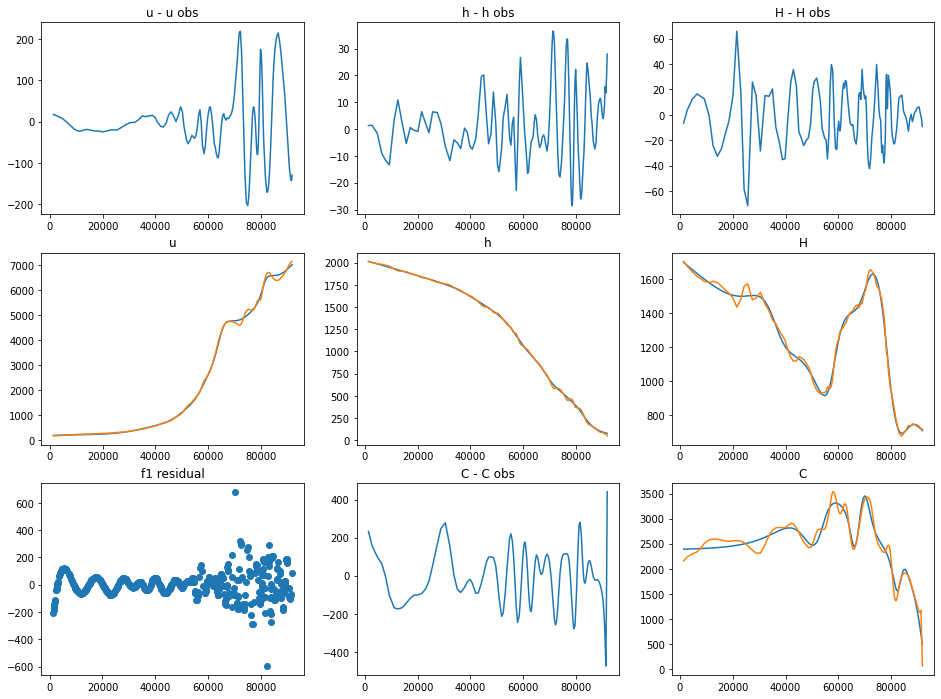

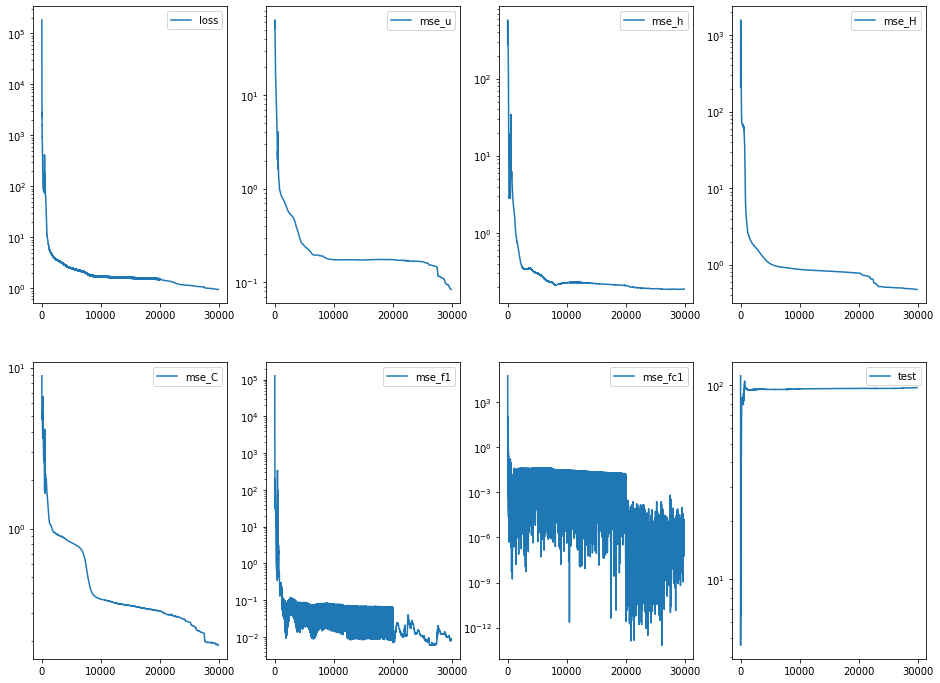

In [9]:
    pinn.save()
    # plot
    plot_1D_solutions_all(pinn, X_f, X_star, u_star, xlb, xub, savePath=modelPath)
    # history
    plot_log_history(pinn, modelPath)